In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

# Task 2

## Step 1: Loading the Dataset

In [2]:
file = "Online_Retail.xlsx"
df = pd.read_excel(file, sheet_name = "Online Retail")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df[["Quantity", "UnitPrice"]].describe()
# df.describe()

,Quantity,UnitPrice
count,250000.000000,250000.000000
mean,9.290204,5.073832
std,218.691045,117.615730
min,-74215.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.100000
75%,10.000000,4.150000
max,74215.000000,38970.000000


## Step 2: Data Cleaning

**Are there any missing values in the dataset? If so, in which columns?**

CustomerID, Description

Used excel formula:
```
=IF(COUNTA(A2:A250001) < ROWS(A2:A250001), "Yes", "No")
```

**Strategy to handle missing values?**

Drop rows with empty CustomerID

Not dropping rows where Description is empty --> not needed in analysis

**Duplicate rows in the dataset?**

Would be dropped in code. Conditional formatting in excel is too expensive.

**Inconsistent data formats?**

Some quantities are negative --> positive

Can also convert unit price for safe measure

Date would be converted to pd.to_datetime()

**Outliers**

Would be replaced by the mean

In [5]:
df.dropna(subset=["CustomerID"], inplace=True)
df.drop_duplicates(inplace=True)
df["Quantity"] = df["Quantity"].abs()
df["UnitPrice"] = df["UnitPrice"].abs()
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


# replace 0s in UnitPrice with the mean of the product's UnitPrice (assumming UnitPrice changes over time)
valid_prices = df[df['UnitPrice'] > 0]
mean_unit_prices = valid_prices.groupby('Description')['UnitPrice'].mean()
def replace_zero_with_mean(row):
    if row['UnitPrice'] == 0:
        return mean_unit_prices.get(row['Description'], 0)
    else:
        return row['UnitPrice']
df['UnitPrice'] = df.apply(replace_zero_with_mean, axis=1)

# Note: Safe option is to go with mean, if UnitPrice does not change over time then we simply replace

In [ ]:
# Verification
# df["Quantity"].min()

# df["UnitPrice"].min()

0.001

## Step 3: Exploring the Data

## Step 4: Feature Engineering

In [6]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['MonthOfYear'] = df['InvoiceDate'].dt.month
def country_group(country):
    if country in ['United Kingdom', 'Germany', 'France']:
        return 'EU'
    elif country in ['USA', "Canada", 'Mexico']:
        return 'North America'
    else:
        return 'Other'
df['Region'] = df['Country'].apply(country_group)


In [7]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,DayOfWeek,MonthOfYear,Region
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Wednesday,12,EU
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,12,EU
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,Wednesday,12,EU
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,12,EU
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,12,EU


## Graphs

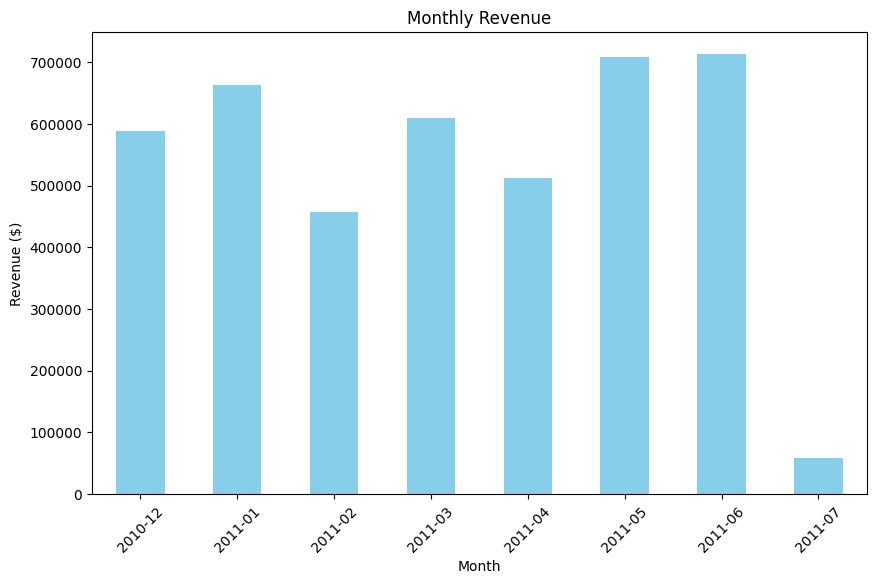

In [8]:
# bar graph for monthly revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_revenue = df.groupby('Month')['Revenue'].sum()

monthly_revenue.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.show()

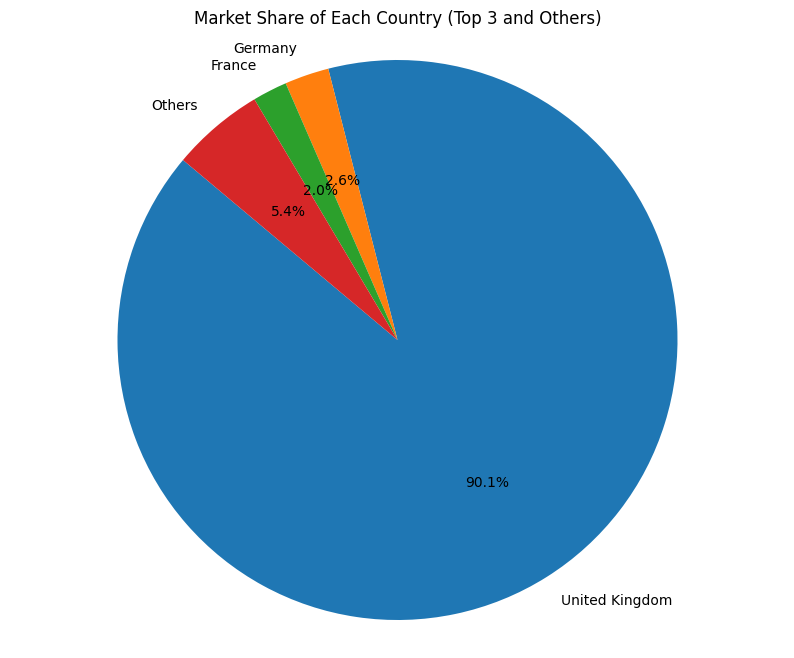

In [9]:
orders_per_country = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)
top_countries = orders_per_country.head(3)
other_countries = orders_per_country[3:].sum()
top_countries['Others'] = other_countries
plt.figure(figsize=(10, 8))
plt.pie(top_countries, labels=top_countries.index, autopct='%1.1f%%', startangle=140)
plt.title('Market Share of Each Country (Top 3 and Others)')
plt.axis('equal')
plt.show()

# Task 3

Task: Predicting total transaction amount

Split the dataset into features (X) and target variable (y)

In [22]:
X = df[['UnitPrice', 'CustomerID', 'MonthOfYear']]
y = df['TotalAmount']

Train and test splits

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression

Mean Absolute Error: 20.812752423859003
Mean Squared Error: 7323.567244974521
R^2 Score: 0.8528037478895455


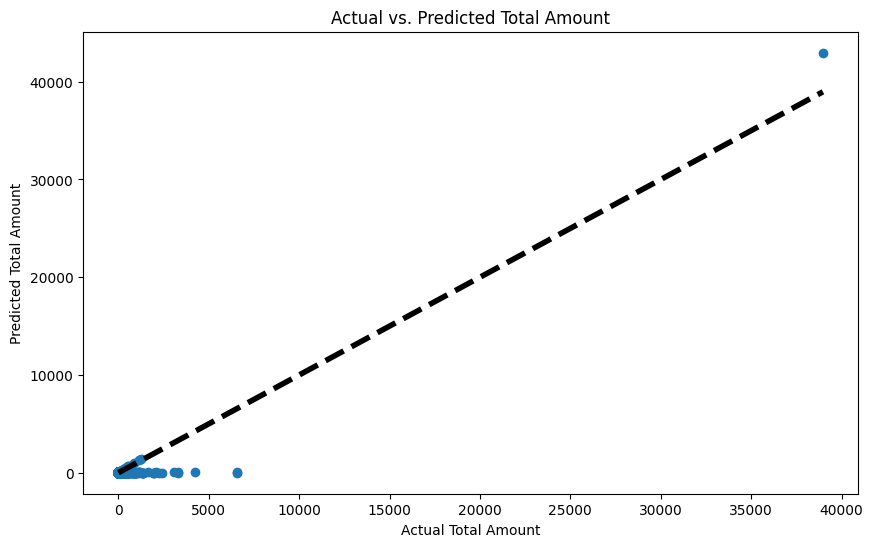

In [24]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Total Amount')
plt.ylabel('Predicted Total Amount')
plt.title('Actual vs. Predicted Total Amount')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

In [12]:
df['IsHighValue'] = df['TotalAmount'] > df['TotalAmount'].quantile(0.75)
df['IsHighValue'] = df['IsHighValue'].astype(int)

X = df[['UnitPrice', 'CustomerID', 'MonthOfYear']]
y = df['IsHighValue']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.7713191393488791
